In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
import yaml

from scipy.stats import binned_statistic_2d
# import shap

from flash_ansr import get_path, ExpressionSpace
from flash_ansr.eval.utils import bootstrapped_metric_ci

In [2]:
N = 1000  # Some were run with 5000 oops, so we'll just use 1000 for consistency

In [3]:
def nan_false_statistic(X, statistic):
    X_copy = np.array(X)
    # Where X is nan, replace with False
    X_copy[np.isnan(X_copy)] = False
    return statistic(X_copy)

In [4]:
MODELS = [os.path.join('analysis_choices_v7.0', m) for m in os.listdir(get_path('results', 'evaluation', 'analysis_choices_v7.0'))]

In [5]:
MODELS_DESCRIPTION = {k: k.replace('v7.0_', '') for k in MODELS}

In [6]:
TEST_SETS = ['train', 'val', 'feynman', 'soose_nc', 'nguyen', 'pool_15']
TEST_SET_TITLES = {
    'train': 'Train',
    'val': 'Val',
    'feynman': 'Feynman',
    'soose_nc': 'S.-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool 15',
}

In [7]:
configs = {}

for model in MODELS:
    with open(get_path(f'configs/{model}/evaluation.yaml'), 'r') as f:
        configs[model] = yaml.safe_load(f)

In [8]:
test_sets = {model: [path.replace('.pickle', '') for path in os.listdir(get_path(f'results/evaluation/{model}'))] for model in MODELS}

for model, model_test_sets in test_sets.items():
    # Reorder the test sets as follows: train, val, feynman, soose_nc, nguyen
    for i, s in enumerate(TEST_SETS):
        if s in model_test_sets:
            model_test_sets.remove(s)
            model_test_sets.insert(i, s)

In [9]:
results = {}

for model, model_test_sets in test_sets.items():
    results[model] = {test_set: {'path': get_path(f'results/evaluation/{model}/{test_set}.pickle')} for test_set in model_test_sets}

In [10]:
remove_invalid = []

for model, model_results in results.items():
    pbar = tqdm(model_results.items(), desc=f'Loading {model} results')
    for test_set, test_set_results in pbar:
        pbar.set_postfix_str(test_set)
        with open(test_set_results['path'], 'rb') as f:
            test_set_results['data'] = pickle.load(f)
            
            for k, v in test_set_results['data'].items():
                test_set_results['data'][k] = v[:N]

            columns_to_rename = set()
            for k, v in test_set_results['data'].items():
                try:
                    test_set_results['data'][k] = np.array(v)
                except ValueError:
                    pass

                if '_free_' in k:
                    columns_to_rename.add(k)

            for k in columns_to_rename:
                test_set_results['data'][k.replace('_free_', '_')] = test_set_results['data'][k]
                del test_set_results['data'][k]

            keys_to_remove = [k for k in test_set_results['data'].keys() if 'residuals' in k]
            keys_to_remove.extend(['x', 'y'])

            for k in keys_to_remove:
                del test_set_results['data'][k]

Loading analysis_choices_v7.0/v7.0_2-choices results: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s, pool_15] 
Loading analysis_choices_v7.0/v7.0_4-choices results: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s, pool_15] 
Loading analysis_choices_v7.0/v7.0_32-choices results: 100%|██████████| 4/4 [00:12<00:00,  3.23s/it, pool_15] 
Loading analysis_choices_v7.0/v7.0_128-choices results: 100%|██████████| 4/4 [00:50<00:00, 12.63s/it, pool_15] 
Loading analysis_choices_v7.0/v7.0_256-choices results: 100%|██████████| 4/4 [01:21<00:00, 20.38s/it, pool_15] 
Loading analysis_choices_v7.0/v7.0_1-choices results: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, pool_15] 
Loading analysis_choices_v7.0/v7.0_16-choices results: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it, pool_15] 
Loading analysis_choices_v7.0/v7.0_64-choices results: 100%|██████████| 4/4 [00:26<00:00,  6.54s/it, pool_15] 
Loading analysis_choices_v7.0/v7.0_8-choices results: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s, pool_15] 


In [11]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    n_restarts = configs[model].get('n_restarts', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        if model == 'pysr':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time'] * 32  # 32 cores
        
        elif model == 'nesymres-100M':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time']

        else:
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time']

100%|██████████| 4/4 [00:00<00:00, 66576.25it/s]


In [12]:
# Replace 'beam_val_' with 'val_beam' in columns where 'beam_val_' is present
for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        columns_before = set(data.keys())
        changed_columns = []
        for k in columns_before:
            if 'beam_val_' in k:
                data[k.replace('beam_val_', 'val_beam_')] = data[k]
                changed_columns.append(k)

        for k in changed_columns:
            del data[k]

100%|██████████| 4/4 [00:00<00:00, 21536.86it/s]


In [13]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        results[model][test_set]['data']['length_target'] = np.array([len(data['input_ids'][i]) for i in range(len(data['input_ids']))])
        
        for j in range(beam_width):
            results[model][test_set]['data'][f'length_beam_{j + 1}'] = np.array([len(data[f'free_beam_{j + 1}'][i]) for i in range(len(data[f'free_beam_{j + 1}']))])

            if f'residuals_beam_{j + 1}' not in data:
                continue
            results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
        
        if '_beam_1' not in data:
            continue

        max_length = max(max([len(beam) for beam in data[f'_beam_{j + 1}']]) for j in range(beam_width))

        for j in range(beam_width):
            padded_beam = [beam + [0] * (max_length - len(beam)) for beam in data[f'_beam_{j + 1}']]
            data[f'_beam_{j + 1}'] = np.array(padded_beam)


100%|██████████| 4/4 [00:00<00:00, 2327.26it/s]


In [14]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    for test_set, test_set_results in tqdm(model_results.items()):
        valid = True
        data = test_set_results['data']

        beam_columns = [k.replace('_beam_1', '') for k in data.keys() if k.endswith(f'beam_1') and not 'residuals' in k and not 'free' in k]

        # Create new columns with metrics of the best beam (by mse_{generation_type}_beam_{i}) and store it as {metric}_{generation_type}_best_beam
        # Create new columns
        for column in beam_columns:
            if isinstance(data[column + '_beam_1'][0], np.ndarray):
                data[column + '_best_beam'] = np.nan * np.ones_like(data[column + '_beam_1'])
            else:
                data[column + '_best_beam'] = np.nan * np.ones(len(data[column + '_beam_1']))

        data['best_beam'] = np.nan * np.ones(len(data['mse_beam_1']))

        # For each instance, find the best beam by mse
        for i in range(len(data['mse_beam_1'])):
            mse_list = np.array([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()])
            if np.all(np.isnan(mse_list)):
                continue
            best_beam = np.nanargmin([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()]) + 1
            data['best_beam'][i] = best_beam
            for column in beam_columns:
                data[column + '_best_beam'][i] = data[column + f'_beam_{best_beam}'][i]

100%|██████████| 4/4 [00:00<00:00, 47.90it/s]


In [15]:
# Design features
for model, model_results in results.items():
    for test_set, test_set_results in model_results.items():
        for maybe_val in ['', '_val']:
            test_set_results['data'][f'is_finite{maybe_val}'] = np.array([np.isfinite(r2) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'FVU-eps_accuracy{maybe_val}'] = np.array([(1 - r2) <= np.finfo(np.float32).eps for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu{maybe_val}'] = np.array([1 - r2 for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])
            test_set_results['data'][f'log_fvu{maybe_val}'] = np.array([np.log10(max(1 - r2, np.finfo(np.float32).eps)) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'] = np.copy(test_set_results['data'][f'fvu{maybe_val}'])
            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'][test_set_results['data'][f'FVU-eps_accuracy{maybe_val}']] = np.nan

            test_set_results['data'][f'log_fvu_not_epsilon{maybe_val}'] = np.array([np.log10(fvu) for fvu in test_set_results['data'][f'fvu_not_epsilon{maybe_val}']])

        if 'perplexity' in test_set_results['data']:
            test_set_results['data']['log_ppl'] = [np.log10(ppl) for ppl in test_set_results['data']['perplexity']]
        else:
            test_set_results['data']['log_ppl'] = [np.nan] * len(test_set_results['data']['r2_best_beam'])

In [16]:
# Find the intersection of the columns of all the dataframes
compare_columns = set.union(*[set(test_set_results['data'].keys()) for model_results in results.values() for test_set_results in model_results.values()])
compare_columns = compare_columns - {'x', 'y', 'y_noisy', 'x_val', 'y_val', 'y_noisy_val', 'constants', 'input_ids', 'labels', 'residuals_beam_1', 'n_support', 'free_best_beam'}
compare_columns = compare_columns - {c for c in compare_columns if any(c.endswith(f'_{i}') or 'free' in c for i in range(1, 1024))}
# compare_columns = compare_columns.union({'perplexity', 'precision_best_beam', 'recall_best_beam', 'meteor_best_beam', 'edit_distance'})
compare_columns

{'FVU-eps_accuracy',
 'FVU-eps_accuracy_val',
 'NSRTS_accuracy_close_best_beam',
 'NSRTS_accuracy_close_val_best_beam',
 'NSRTS_accuracy_r2_best_beam',
 'NSRTS_accuracy_r2_val_best_beam',
 'accuracy_best_beam',
 'best_beam',
 'bleu_best_beam',
 'edit_distance_best_beam',
 'f1_score_best_beam',
 'fit_time',
 'fvu',
 'fvu_not_epsilon',
 'fvu_not_epsilon_val',
 'fvu_val',
 'is_finite',
 'is_finite_val',
 'length_best_beam',
 'length_target',
 'log_fvu',
 'log_fvu_not_epsilon',
 'log_fvu_not_epsilon_val',
 'log_fvu_val',
 'log_ppl',
 'meteor_best_beam',
 'mse_best_beam',
 'mse_val_best_beam',
 'perplexity',
 'precision_best_beam',
 'r2_best_beam',
 'r2_val_best_beam',
 'recall_best_beam',
 'reciprocal_rank',
 'rouge1_fmeasure_best_beam',
 'rouge1_precision_best_beam',
 'rouge1_recall_best_beam',
 'rouge2_fmeasure_best_beam',
 'rouge2_precision_best_beam',
 'rouge2_recall_best_beam',
 'rougeL_fmeasure_best_beam',
 'rougeL_precision_best_beam',
 'rougeL_recall_best_beam',
 'structural_accura

In [17]:
array_dfs = {
    model: {
        test_set:
        pd.DataFrame({k: v for k, v in test_set_results['data'].items() if k in compare_columns}).astype(float)
            for test_set, test_set_results in model_results.items()}
            for model, model_results in results.items()}

In [18]:
compare_columns_defaults = {
    'FVU-eps_accuracy': 0,
    'perplexity': np.inf,
    'log_ppl': np.inf,
    'precision_best_beam': 0,
    'recall_best_beam': 0,
    'L_inf_best_beam': np.inf,
    'NSRTS_accuracy_close_best_beam': 0,
    'NSRTS_accuracy_r2_best_beam': 0,
    'NSRTS_accuracy_close_val_best_beam': 0,
    'NSRTS_accuracy_r2_val_best_beam': 0,
    'accuracy_best_beam': 0,
    'bleu_best_beam': 0,
    'edit_distance_best_beam': np.inf,
    'f1_score_best_beam': 0,
    'fvu': np.inf,
    'log_fvu': np.inf,
    'fvu_not_epsilon': np.inf,
    'log_fvu_not_epsilon': np.inf,
    'log_ppl': np.inf,
    'meteor_best_beam': 0,
    'mse_best_beam': np.inf,
    'mse_val_best_beam': np.inf,
    'perplexity': np.inf,
    'precision_best_beam': 0,
    'r2_best_beam': -np.inf,
    'r2_val_best_beam': -np.inf,
    'recall_best_beam': 0,
    'reciprocal_rank': 0,
    'rouge1_fmeasure_best_beam': 0,
    'rouge1_precision_best_beam': 0,
    'rouge1_recall_best_beam': 0,
    'rouge2_fmeasure_best_beam': 0,
    'rouge2_precision_best_beam': 0,
    'rouge2_recall_best_beam': 0,
    'rougeL_fmeasure_best_beam': 0,
    'rougeL_precision_best_beam': 0,
    'rougeL_recall_best_beam': 0,
    'structural_accuracy_best_beam': 0,
    'tree_edit_distance_best_beam': np.inf,
    'wall_time': np.inf,
    'sys_time': np.inf,
    'is_finite': 0,
}

In [19]:
from functools import partial

In [20]:
def naninfmean(x):
    return np.nanmean(np.array(x)[np.isfinite(x)])

# Per Dataset

In [21]:
summaries = {model: {test_set: {column: {} for column in compare_columns} for test_set, df in model_dfs.items()} for model, model_dfs in array_dfs.items()}
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        for column in tqdm(compare_columns, desc=f'{model} {test_set}'):
            sub_metrics = ['mean', 'median', '2.5p', '97.5p']
            sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]
            if column in df.columns:
                data = df[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                summaries[model][test_set][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
            else:
                summaries[model][test_set][column] = {k: (np.nan, ) * 3 for k in sub_metrics}

            if metrics is None:
                metrics = summaries[model][test_set][column].keys()

analysis_choices_v7.0/v7.0_2-choices feynman:  11%|█         | 5/47 [00:00<00:04,  9.63it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_choices_v7.0/v7.0_2-choices pool_15:  38%|███▊      | 18/47 [00:02<00:03,  8.69it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4622: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
analysis_choices_v7.0/v7.0_8-choices pool_15: 100%|██████████| 47/47 [00:05<00:00,  9.26it/s]


In [22]:
# Show a summary table for each metric
# In each table, the rows are the models and the columns are the test sets
# For columns with 'accuracy' in the name, show the mean. For other columns show the median.

summary_tables = {
    column: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    test_set: summaries[model][test_set][column][metric][k]
                    for test_set in summaries[model].keys()}
                    for model in summaries.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for column in compare_columns}

#### Validity

In [23]:
m = 'is_finite'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"0.997 (0.993, 1.0)","0.992 (0.986, 0.997)","0.992 (0.986, 0.997)","0.987 (0.979, 0.994)"
analysis_choices_v7.0/v7.0_4-choices,"1.0 (1.0, 1.0)","0.997 (0.993, 1.0)","0.998 (0.995, 1.0)","0.997 (0.993, 1.0)"
analysis_choices_v7.0/v7.0_32-choices,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_choices_v7.0/v7.0_128-choices,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_choices_v7.0/v7.0_256-choices,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_choices_v7.0/v7.0_1-choices,"0.969 (0.958, 0.979)","0.96 (0.946, 0.971)","0.973 (0.962, 0.983)","0.954 (0.939, 0.966)"
analysis_choices_v7.0/v7.0_16-choices,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_choices_v7.0/v7.0_64-choices,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_choices_v7.0/v7.0_8-choices,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"


#### Recovery Rate

In [24]:
m = 'NSRTS_accuracy_close_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"0.697 (0.67, 0.726)","0.483 (0.453, 0.513)","0.592 (0.562, 0.62)","0.462 (0.432, 0.493)"
analysis_choices_v7.0/v7.0_4-choices,"0.759 (0.733, 0.784)","0.568 (0.538, 0.596)","0.667 (0.639, 0.697)","0.499 (0.469, 0.529)"
analysis_choices_v7.0/v7.0_32-choices,"0.848 (0.825, 0.871)","0.773 (0.748, 0.799)","0.847 (0.823, 0.867)","0.636 (0.606, 0.667)"
analysis_choices_v7.0/v7.0_128-choices,"0.916 (0.898, 0.931)","0.855 (0.833, 0.877)","0.913 (0.895, 0.929)","0.68 (0.65, 0.707)"
analysis_choices_v7.0/v7.0_256-choices,"0.935 (0.92, 0.95)","0.865 (0.844, 0.885)","0.963 (0.951, 0.974)","0.698 (0.671, 0.727)"
analysis_choices_v7.0/v7.0_1-choices,"0.596 (0.565, 0.627)","0.369 (0.34, 0.4)","0.454 (0.425, 0.484)","0.361 (0.331, 0.389)"
analysis_choices_v7.0/v7.0_16-choices,"0.834 (0.811, 0.856)","0.718 (0.689, 0.745)","0.78 (0.753, 0.806)","0.582 (0.552, 0.611)"
analysis_choices_v7.0/v7.0_64-choices,"0.875 (0.854, 0.896)","0.824 (0.802, 0.847)","0.899 (0.88, 0.916)","0.664 (0.635, 0.691)"
analysis_choices_v7.0/v7.0_8-choices,"0.815 (0.791, 0.839)","0.669 (0.639, 0.696)","0.745 (0.716, 0.772)","0.546 (0.513, 0.575)"


In [25]:
m = 'NSRTS_accuracy_r2_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"0.799 (0.774, 0.826)","0.611 (0.582, 0.643)","0.819 (0.794, 0.842)","0.621 (0.592, 0.652)"
analysis_choices_v7.0/v7.0_4-choices,"0.848 (0.826, 0.871)","0.698 (0.666, 0.724)","0.891 (0.87, 0.909)","0.676 (0.648, 0.704)"
analysis_choices_v7.0/v7.0_32-choices,"0.92 (0.903, 0.936)","0.854 (0.832, 0.875)","0.976 (0.966, 0.985)","0.816 (0.792, 0.84)"
analysis_choices_v7.0/v7.0_128-choices,"0.96 (0.948, 0.972)","0.9 (0.881, 0.919)","0.994 (0.988, 0.998)","0.887 (0.868, 0.906)"
analysis_choices_v7.0/v7.0_256-choices,"0.974 (0.964, 0.983)","0.896 (0.877, 0.913)","0.998 (0.995, 1.0)","0.882 (0.861, 0.903)"
analysis_choices_v7.0/v7.0_1-choices,"0.681 (0.65, 0.71)","0.491 (0.462, 0.522)","0.665 (0.636, 0.693)","0.468 (0.435, 0.498)"
analysis_choices_v7.0/v7.0_16-choices,"0.9 (0.88, 0.919)","0.814 (0.791, 0.838)","0.946 (0.931, 0.961)","0.803 (0.778, 0.825)"
analysis_choices_v7.0/v7.0_64-choices,"0.944 (0.929, 0.957)","0.881 (0.862, 0.9)","0.989 (0.982, 0.994)","0.848 (0.825, 0.869)"
analysis_choices_v7.0/v7.0_8-choices,"0.898 (0.879, 0.916)","0.786 (0.759, 0.81)","0.929 (0.914, 0.945)","0.75 (0.723, 0.775)"


In [26]:
m = 'FVU-eps_accuracy'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"0.583 (0.549, 0.611)","0.342 (0.312, 0.368)","0.428 (0.398, 0.459)","0.246 (0.22, 0.274)"
analysis_choices_v7.0/v7.0_4-choices,"0.641 (0.61, 0.672)","0.41 (0.383, 0.441)","0.475 (0.444, 0.507)","0.25 (0.223, 0.276)"
analysis_choices_v7.0/v7.0_32-choices,"0.728 (0.702, 0.754)","0.634 (0.605, 0.663)","0.796 (0.771, 0.821)","0.344 (0.316, 0.374)"
analysis_choices_v7.0/v7.0_128-choices,"0.807 (0.784, 0.832)","0.756 (0.729, 0.783)","0.896 (0.877, 0.913)","0.38 (0.352, 0.412)"
analysis_choices_v7.0/v7.0_256-choices,"0.82 (0.795, 0.843)","0.795 (0.769, 0.82)","0.927 (0.91, 0.943)","0.441 (0.412, 0.472)"
analysis_choices_v7.0/v7.0_1-choices,"0.508 (0.478, 0.538)","0.256 (0.231, 0.282)","0.301 (0.273, 0.331)","0.192 (0.167, 0.216)"
analysis_choices_v7.0/v7.0_16-choices,"0.723 (0.694, 0.752)","0.563 (0.533, 0.595)","0.651 (0.62, 0.68)","0.342 (0.313, 0.37)"
analysis_choices_v7.0/v7.0_64-choices,"0.738 (0.712, 0.764)","0.72 (0.691, 0.748)","0.861 (0.839, 0.88)","0.401 (0.373, 0.432)"
analysis_choices_v7.0/v7.0_8-choices,"0.71 (0.681, 0.737)","0.487 (0.455, 0.518)","0.564 (0.535, 0.594)","0.301 (0.271, 0.33)"


In [27]:
m = 'FVU-eps_accuracy_val'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"0.577 (0.547, 0.61)","0.338 (0.311, 0.367)","0.428 (0.397, 0.458)","0.237 (0.212, 0.264)"
analysis_choices_v7.0/v7.0_4-choices,"0.636 (0.605, 0.665)","0.408 (0.378, 0.438)","0.477 (0.446, 0.504)","0.249 (0.224, 0.275)"
analysis_choices_v7.0/v7.0_32-choices,"0.725 (0.698, 0.753)","0.635 (0.605, 0.665)","0.795 (0.773, 0.822)","0.341 (0.313, 0.371)"
analysis_choices_v7.0/v7.0_128-choices,"0.81 (0.784, 0.834)","0.754 (0.727, 0.779)","0.897 (0.878, 0.916)","0.376 (0.347, 0.406)"
analysis_choices_v7.0/v7.0_256-choices,"0.813 (0.789, 0.836)","0.794 (0.769, 0.819)","0.927 (0.911, 0.943)","0.443 (0.415, 0.474)"
analysis_choices_v7.0/v7.0_1-choices,"0.506 (0.474, 0.537)","0.258 (0.231, 0.283)","0.302 (0.274, 0.331)","0.19 (0.165, 0.213)"
analysis_choices_v7.0/v7.0_16-choices,"0.723 (0.694, 0.749)","0.561 (0.53, 0.592)","0.65 (0.621, 0.68)","0.338 (0.309, 0.368)"
analysis_choices_v7.0/v7.0_64-choices,"0.733 (0.705, 0.762)","0.717 (0.688, 0.744)","0.862 (0.84, 0.883)","0.396 (0.366, 0.424)"
analysis_choices_v7.0/v7.0_8-choices,"0.708 (0.678, 0.735)","0.485 (0.456, 0.517)","0.565 (0.535, 0.594)","0.293 (0.264, 0.321)"


#### Numeric Error

In [28]:
m = 'fvu_not_epsilon'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"1.331 (0.509, 2.921)","24.649 (1.293, 74.727)","5.488 (0.379, 16.186)","12882.623 (7.31, 39953.541)"
analysis_choices_v7.0/v7.0_4-choices,"0.411 (0.297, 0.595)","0.537 (0.478, 0.601)","0.181 (0.126, 0.281)","1.766 (0.412, 3.877)"
analysis_choices_v7.0/v7.0_32-choices,"0.2 (0.157, 0.244)","0.358 (0.306, 0.414)","0.027 (0.015, 0.041)","0.167 (0.143, 0.193)"
analysis_choices_v7.0/v7.0_128-choices,"0.144 (0.1, 0.191)","0.303 (0.247, 0.363)","0.009 (0.003, 0.017)","0.1 (0.081, 0.122)"
analysis_choices_v7.0/v7.0_256-choices,"0.061 (0.035, 0.092)","0.365 (0.305, 0.424)","0.005 (0.001, 0.01)","0.107 (0.087, 0.129)"
analysis_choices_v7.0/v7.0_1-choices,"7718173969.167 (21.269, 24413171271.25)","100993442714.925 (6.188, 309559017699.751)","41988.301 (10.576, 129607.161)","8506877630.512 (1771840.558, 26182741593.934)"
analysis_choices_v7.0/v7.0_16-choices,"0.26 (0.214, 0.309)","0.374 (0.326, 0.426)","0.057 (0.04, 0.077)","0.191 (0.163, 0.22)"
analysis_choices_v7.0/v7.0_64-choices,"0.141 (0.101, 0.185)","0.357 (0.303, 0.416)","0.017 (0.007, 0.031)","0.152 (0.129, 0.18)"
analysis_choices_v7.0/v7.0_8-choices,"0.273 (0.223, 0.324)","0.54 (0.351, 0.918)","0.08 (0.06, 0.103)","51.163 (0.215, 156.264)"


In [29]:
m = 'fvu_not_epsilon_val'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"288.956 (3.115, 921.879)","9674.877 (11.874, 36511.133)","5.287 (0.384, 15.346)","5.00641784395735e+16 (40.709, 1.53462032686175..."
analysis_choices_v7.0/v7.0_4-choices,"21.315 (0.64, 64.545)","9.358 (1.004, 23.396)","0.183 (0.127, 0.283)","4.223724353769452e+76 (88.195, 1.2982797017851..."
analysis_choices_v7.0/v7.0_32-choices,"89224286.706 (215.079, 285612691.712)","10.678 (1.366, 26.196)","0.028 (0.016, 0.044)","86078.815 (6.752, 267776.539)"
analysis_choices_v7.0/v7.0_128-choices,"1.071 (0.278, 2.249)","2.018 (0.491, 5.321)","0.01 (0.004, 0.018)","482.314 (3.108, 1459.8)"
analysis_choices_v7.0/v7.0_256-choices,"2.449 (0.237, 7.195)","87.971 (0.925, 302.846)","0.005 (0.001, 0.011)","668.159 (2.085, 2256.253)"
analysis_choices_v7.0/v7.0_1-choices,"931346699.878 (2302.195, 2955116707.519)","61437.284 (17.787, 188370.583)","4589145238064.634 (37.797, 14100716694123.406)","36982846683243.57 (8655646.215, 11315543502248..."
analysis_choices_v7.0/v7.0_16-choices,"110.241 (3.593, 331.956)","0.724 (0.509, 1.028)","0.059 (0.042, 0.081)","3.1005817817890734e+25 (9.55, 9.57443083453248..."
analysis_choices_v7.0/v7.0_64-choices,"2.313 (0.479, 6.312)","2.191 (0.839, 4.358)","0.018 (0.007, 0.034)","61.861 (2.663, 149.838)"
analysis_choices_v7.0/v7.0_8-choices,"44788.487 (1.187, 149011.369)","101.651 (3.041, 364.803)","0.083 (0.061, 0.106)","2749.707 (0.735, 8551.695)"


#### Time

In [30]:
m = 'wall_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"0.116 (0.113, 0.121)","0.115 (0.111, 0.118)","0.089 (0.087, 0.093)","0.138 (0.136, 0.143)"
analysis_choices_v7.0/v7.0_4-choices,"0.137 (0.133, 0.142)","0.136 (0.132, 0.139)","0.122 (0.118, 0.125)","0.183 (0.18, 0.188)"
analysis_choices_v7.0/v7.0_32-choices,"0.421 (0.407, 0.435)","0.416 (0.408, 0.423)","0.371 (0.362, 0.378)","0.583 (0.569, 0.597)"
analysis_choices_v7.0/v7.0_128-choices,"1.3 (1.267, 1.352)","1.384 (1.344, 1.418)","1.208 (1.177, 1.239)","2.095 (2.029, 2.164)"
analysis_choices_v7.0/v7.0_256-choices,"2.524 (2.458, 2.648)","2.765 (2.679, 2.841)","2.28 (2.223, 2.332)","3.97 (3.855, 4.097)"
analysis_choices_v7.0/v7.0_1-choices,"0.087 (0.085, 0.09)","0.086 (0.084, 0.088)","0.068 (0.067, 0.071)","0.125 (0.122, 0.13)"
analysis_choices_v7.0/v7.0_16-choices,"0.266 (0.256, 0.273)","0.278 (0.271, 0.285)","0.234 (0.229, 0.24)","0.362 (0.352, 0.372)"
analysis_choices_v7.0/v7.0_64-choices,"0.737 (0.718, 0.762)","0.764 (0.745, 0.787)","0.633 (0.619, 0.648)","1.076 (1.043, 1.11)"
analysis_choices_v7.0/v7.0_8-choices,"0.172 (0.167, 0.178)","0.175 (0.171, 0.179)","0.159 (0.153, 0.163)","0.23 (0.226, 0.236)"


In [31]:
m = 'sys_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"0.116 (0.112, 0.12)","0.115 (0.111, 0.118)","0.089 (0.087, 0.093)","0.138 (0.136, 0.142)"
analysis_choices_v7.0/v7.0_4-choices,"0.138 (0.133, 0.142)","0.136 (0.132, 0.14)","0.122 (0.118, 0.125)","0.183 (0.18, 0.188)"
analysis_choices_v7.0/v7.0_32-choices,"0.42 (0.407, 0.436)","0.415 (0.407, 0.423)","0.37 (0.362, 0.38)","0.583 (0.571, 0.6)"
analysis_choices_v7.0/v7.0_128-choices,"1.299 (1.266, 1.353)","1.383 (1.345, 1.415)","1.207 (1.177, 1.237)","2.095 (2.03, 2.166)"
analysis_choices_v7.0/v7.0_256-choices,"2.532 (2.458, 2.648)","2.765 (2.68, 2.825)","2.281 (2.225, 2.34)","3.963 (3.856, 4.094)"
analysis_choices_v7.0/v7.0_1-choices,"0.087 (0.085, 0.09)","0.086 (0.083, 0.088)","0.068 (0.067, 0.071)","0.125 (0.122, 0.129)"
analysis_choices_v7.0/v7.0_16-choices,"0.266 (0.257, 0.272)","0.278 (0.27, 0.286)","0.234 (0.229, 0.24)","0.362 (0.351, 0.373)"
analysis_choices_v7.0/v7.0_64-choices,"0.737 (0.718, 0.762)","0.765 (0.746, 0.787)","0.633 (0.617, 0.647)","1.076 (1.044, 1.113)"
analysis_choices_v7.0/v7.0_8-choices,"0.172 (0.167, 0.18)","0.174 (0.171, 0.18)","0.159 (0.154, 0.163)","0.23 (0.225, 0.236)"


#### Text Metrics

In [32]:
m = 'perplexity'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"2.412 (2.186, 2.735)","2.009 (1.842, 2.134)","4.908 (4.371, 6.104)","16.786 (13.919, 20.279)"
analysis_choices_v7.0/v7.0_4-choices,"2.143 (1.994, 2.363)","2.178 (1.979, 2.29)","4.99 (4.442, 5.316)","20.809 (17.563, 25.431)"
analysis_choices_v7.0/v7.0_32-choices,"2.391 (2.216, 2.66)","2.066 (1.941, 2.212)","5.782 (4.864, 6.957)","16.012 (13.836, 19.056)"
analysis_choices_v7.0/v7.0_128-choices,"2.357 (2.188, 2.515)","2.11 (1.978, 2.27)","5.656 (4.91, 6.694)","18.977 (15.55, 22.268)"
analysis_choices_v7.0/v7.0_256-choices,"2.267 (2.146, 2.518)","2.162 (2.046, 2.347)","4.822 (3.961, 5.62)","17.679 (14.622, 20.307)"
analysis_choices_v7.0/v7.0_1-choices,"2.381 (2.226, 2.629)","2.056 (1.937, 2.265)","5.505 (4.781, 6.189)","15.894 (13.242, 19.257)"
analysis_choices_v7.0/v7.0_16-choices,"2.255 (2.064, 2.557)","2.043 (1.939, 2.209)","5.082 (4.493, 5.786)","18.277 (15.664, 22.316)"
analysis_choices_v7.0/v7.0_64-choices,"2.3 (2.099, 2.584)","1.984 (1.846, 2.106)","4.899 (4.299, 5.656)","15.113 (13.104, 18.315)"
analysis_choices_v7.0/v7.0_8-choices,"2.229 (2.073, 2.421)","2.112 (1.988, 2.296)","5.169 (4.545, 6.01)","15.993 (12.94, 19.641)"


In [33]:
m = 'tree_edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"14.083 (13.418, 14.701)","13.153 (12.581, 13.685)","15.371 (14.665, 16.14)","25.353 (24.532, 26.144)"
analysis_choices_v7.0/v7.0_4-choices,"13.203 (12.49, 13.902)","12.802 (12.213, 13.399)","15.819 (15.031, 16.533)","26.467 (25.753, 27.22)"
analysis_choices_v7.0/v7.0_32-choices,"13.688 (13.043, 14.351)","10.813 (10.097, 11.477)","14.795 (13.961, 15.662)","25.63 (24.812, 26.452)"
analysis_choices_v7.0/v7.0_128-choices,"13.926 (13.213, 14.643)","9.797 (9.146, 10.435)","14.328 (13.585, 15.145)","26.09 (25.265, 26.856)"
analysis_choices_v7.0/v7.0_256-choices,"14.204 (13.448, 14.919)","9.734 (9.066, 10.479)","13.41 (12.57, 14.225)","26.058 (25.218, 26.838)"
analysis_choices_v7.0/v7.0_1-choices,"14.944 (14.323, 15.556)","13.695 (13.125, 14.238)","16.246 (15.559, 16.971)","25.421 (24.647, 26.215)"
analysis_choices_v7.0/v7.0_16-choices,"12.734 (12.023, 13.445)","11.695 (11.029, 12.295)","15.22 (14.457, 16.01)","25.534 (24.73, 26.337)"
analysis_choices_v7.0/v7.0_64-choices,"13.657 (12.941, 14.336)","10.29 (9.598, 10.96)","13.971 (13.108, 14.776)","25.294 (24.508, 26.05)"
analysis_choices_v7.0/v7.0_8-choices,"12.732 (12.018, 13.434)","12.24 (11.609, 12.866)","15.544 (14.753, 16.301)","25.626 (24.899, 26.436)"


In [34]:
m = 'f1_score_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"0.866 (0.858, 0.874)","0.82 (0.81, 0.83)","0.736 (0.724, 0.748)","0.804 (0.795, 0.813)"
analysis_choices_v7.0/v7.0_4-choices,"0.882 (0.875, 0.89)","0.831 (0.821, 0.841)","0.749 (0.738, 0.76)","0.808 (0.799, 0.816)"
analysis_choices_v7.0/v7.0_32-choices,"0.895 (0.888, 0.901)","0.869 (0.859, 0.878)","0.769 (0.757, 0.782)","0.833 (0.826, 0.841)"
analysis_choices_v7.0/v7.0_128-choices,"0.898 (0.892, 0.904)","0.896 (0.888, 0.904)","0.793 (0.78, 0.804)","0.837 (0.829, 0.844)"
analysis_choices_v7.0/v7.0_256-choices,"0.898 (0.893, 0.904)","0.898 (0.889, 0.907)","0.811 (0.8, 0.823)","0.84 (0.832, 0.847)"
analysis_choices_v7.0/v7.0_1-choices,"0.826 (0.815, 0.838)","0.784 (0.769, 0.797)","0.698 (0.685, 0.71)","0.774 (0.761, 0.786)"
analysis_choices_v7.0/v7.0_16-choices,"0.893 (0.886, 0.899)","0.857 (0.848, 0.867)","0.764 (0.753, 0.777)","0.826 (0.818, 0.833)"
analysis_choices_v7.0/v7.0_64-choices,"0.891 (0.884, 0.898)","0.881 (0.872, 0.89)","0.794 (0.781, 0.806)","0.833 (0.825, 0.84)"
analysis_choices_v7.0/v7.0_8-choices,"0.895 (0.888, 0.901)","0.841 (0.831, 0.85)","0.749 (0.738, 0.761)","0.825 (0.816, 0.832)"


In [35]:
m = 'meteor_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"0.649 (0.634, 0.665)","0.638 (0.622, 0.653)","0.522 (0.505, 0.539)","0.473 (0.459, 0.487)"
analysis_choices_v7.0/v7.0_4-choices,"0.696 (0.683, 0.711)","0.656 (0.64, 0.673)","0.535 (0.517, 0.554)","0.461 (0.449, 0.473)"
analysis_choices_v7.0/v7.0_32-choices,"0.697 (0.683, 0.712)","0.738 (0.723, 0.754)","0.6 (0.581, 0.619)","0.503 (0.489, 0.517)"
analysis_choices_v7.0/v7.0_128-choices,"0.708 (0.693, 0.723)","0.776 (0.759, 0.791)","0.635 (0.617, 0.654)","0.511 (0.498, 0.525)"
analysis_choices_v7.0/v7.0_256-choices,"0.699 (0.685, 0.714)","0.784 (0.769, 0.8)","0.666 (0.649, 0.684)","0.531 (0.516, 0.545)"
analysis_choices_v7.0/v7.0_1-choices,"0.604 (0.588, 0.619)","0.595 (0.579, 0.611)","0.472 (0.455, 0.488)","0.443 (0.428, 0.456)"
analysis_choices_v7.0/v7.0_16-choices,"0.717 (0.701, 0.732)","0.71 (0.691, 0.726)","0.579 (0.56, 0.598)","0.5 (0.487, 0.514)"
analysis_choices_v7.0/v7.0_64-choices,"0.706 (0.691, 0.722)","0.758 (0.741, 0.773)","0.638 (0.62, 0.658)","0.515 (0.502, 0.529)"
analysis_choices_v7.0/v7.0_8-choices,"0.71 (0.695, 0.725)","0.688 (0.669, 0.704)","0.546 (0.528, 0.565)","0.488 (0.474, 0.501)"


In [36]:
m = 'edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"5.427 (5.191, 5.661)","5.283 (5.06, 5.505)","5.304 (5.069, 5.545)","9.962 (9.655, 10.27)"
analysis_choices_v7.0/v7.0_4-choices,"4.989 (4.745, 5.228)","5.025 (4.791, 5.258)","5.296 (5.06, 5.536)","10.315 (10.016, 10.622)"
analysis_choices_v7.0/v7.0_32-choices,"5.274 (5.007, 5.529)","4.112 (3.859, 4.379)","4.74 (4.478, 4.979)","9.984 (9.67, 10.298)"
analysis_choices_v7.0/v7.0_128-choices,"5.408 (5.171, 5.657)","3.745 (3.499, 3.975)","4.63 (4.373, 4.905)","10.105 (9.81, 10.443)"
analysis_choices_v7.0/v7.0_256-choices,"5.519 (5.271, 5.785)","3.679 (3.43, 3.934)","4.376 (4.11, 4.634)","10.008 (9.707, 10.322)"
analysis_choices_v7.0/v7.0_1-choices,"5.857 (5.624, 6.106)","5.517 (5.29, 5.748)","5.598 (5.389, 5.826)","10.077 (9.785, 10.37)"
analysis_choices_v7.0/v7.0_16-choices,"4.855 (4.617, 5.113)","4.395 (4.165, 4.64)","4.934 (4.69, 5.154)","9.908 (9.591, 10.193)"
analysis_choices_v7.0/v7.0_64-choices,"5.265 (5.003, 5.505)","3.884 (3.666, 4.127)","4.51 (4.248, 4.758)","9.82 (9.505, 10.106)"
analysis_choices_v7.0/v7.0_8-choices,"4.901 (4.66, 5.144)","4.682 (4.44, 4.927)","5.13 (4.874, 5.374)","10.038 (9.77, 10.341)"


In [37]:
def table_to_typst(tables, column, metric, caption, test_set_titles, tag, negate=False, objective='max', font_size=9, ci_font_size=7, fmt_fn=None, factor=1):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    main_df = tables[column][metric]['median'] * (-1 if negate else 1)
    lower_df = tables[column][metric]['lower'] * (-1 if negate else 1)
    upper_df = tables[column][metric]['upper'] * (-1 if negate else 1)

    # Determine the best model for each test set
    best_model = main_df.idxmax(axis=0) if objective == 'max' else main_df.idxmin(axis=0)

    if objective == 'max':
        equal_mask = pd.DataFrame({test_set: upper_df[test_set] >= lower_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in upper_df})
    else:
        equal_mask = pd.DataFrame({test_set: lower_df[test_set] <= upper_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in lower_df})

    # print(equal_mask)

    output = f'''
#figure(
  [
    #show <table_CI>: set text({ci_font_size}pt)
    #text(
    size:{font_size}pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {{
      (right: (
      thickness: 0.5pt,
      ))
    }},
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
'''

    output += f"  [*Model*], "
    for test_set in test_set_titles.values():
        output += f"[*{test_set}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"

    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        flash = '#emoji.lightning ' if main_row[0].startswith('v') else ''
        output += f"  [{flash + MODELS_DESCRIPTION[main_row[0]]}], "
        output += ", ".join([
            '[' + ("*" if equal_best_row[1].get(test_set, False) else '') + f"{fmt_fn(main_row[1].get(test_set, np.nan) * factor)}\ ({fmt_fn(lower_row[1].get(test_set, np.nan) * factor)}, {fmt_fn(upper_row[1].get(test_set, np.nan) * factor)}) <table_CI>" + ("*" if equal_best_row[1].get(test_set, False) else '') + ']'
            for test_set in test_set_titles.keys()
        ]) + ",\n"

    output = output.replace('nan', '---')

    output += f'''
    table.hline(),
  ))],
  caption: [{caption}],
  gap: 1.2em,
) <{tag}>
'''

    return output

def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [38]:
print(table_to_typst(summary_tables, 'FVU-eps_accuracy', 'mean', caption='*Recovery Rate in $bold("%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_fvu_eps_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_choices_v7.0/2-choices], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [58.3\ (54.9, 61.1) <table_CI>], [34.2\ (31.2, 36.8) <table_CI>], [42.8\ (39.8, 45.9) <table_CI>], [24.6\ (22.0, 27.4) <table_CI>],
  [analysis_choices_v7.0/4-choices], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [64.1\ (61.0, 67.2) <table_CI>], [41.0\ (38.3, 44.1) <table_CI>], [47.5\ (44.4, 50.7) <table_CI>], [25.0\ (22.3, 27.6) <table_CI>],
  [analysis_choices_v7.0/32-choices], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [72.8\ (70.2, 75.4) <t

In [39]:
print(table_to_typst(summary_tables, 'NSRTS_accuracy_r2_best_beam', 'mean', caption='*Recovery Rate in $bold("%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_r2_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_choices_v7.0/2-choices], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [79.9\ (77.4, 82.6) <table_CI>], [61.1\ (58.2, 64.3) <table_CI>], [81.9\ (79.4, 84.2) <table_CI>], [62.1\ (59.2, 65.2) <table_CI>],
  [analysis_choices_v7.0/4-choices], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [84.8\ (82.6, 87.1) <table_CI>], [69.8\ (66.6, 72.4) <table_CI>], [89.1\ (87.0, 90.9) <table_CI>], [67.6\ (64.8, 70.4) <table_CI>],
  [analysis_choices_v7.0/32-choices], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [92.0\ (90.3, 93.6) <t

In [40]:
print(table_to_typst(summary_tables, 'edit_distance_best_beam', 'mean', caption='*Levenshtein Edit Distance $bold(attach(arrow.b, tr:[0, oo]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_edit_distance', objective='min'))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_choices_v7.0/2-choices], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [5.43\ (5.19, 5.66) <table_CI>], [5.28\ (5.06, 5.50) <table_CI>], [5.30\ (5.07, 5.54) <table_CI>], [*9.96\ (9.65, 10.27) <table_CI>*],
  [analysis_choices_v7.0/4-choices], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*4.99\ (4.75, 5.23) <table_CI>*], [5.03\ (4.79, 5.26) <table_CI>], [5.30\ (5.06, 5.54) <table_CI>], [*10.31\ (10.02, 10.62) <table_CI>*],
  [analysis_choices_v7.0/32-choices], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*5.27\ (5.0

# Aggregated

In [41]:
def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [42]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary = {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data = pd.concat([df for test_set, df in model_dfs.items() if test_set in aggregate_sets])

    for column in tqdm(compare_columns, desc=f'{model}'):
        if column in aggregated_data.columns:
            data = aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
            total_summary[model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary[model][column].keys()

analysis_choices_v7.0/v7.0_2-choices:  11%|█         | 5/47 [00:01<00:10,  4.16it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_choices_v7.0/v7.0_8-choices:  96%|█████████▌| 45/47 [00:10<00:00,  5.05it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4623: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
analysis_choices_v7.0/v7.0_8-choices: 100%|██████████| 47/47 [00:10<00:00,  4.41it/s]


In [43]:
total_summary_tables = {
    metric: {
        percentile:
            pd.DataFrame({
            model: {
                column: total_summary[model][column][metric][k]
                for column in compare_columns}
                for model in total_summary.keys()}).T.round(3)
                for k, percentile in enumerate(['median', 'lower', 'upper'])}
                for metric in metrics}

In [44]:
columns = [c for c in total_summary_tables['mean']['median'].T.index if 'accuracy' in c]
total_summary_tables['mean']['median'].T.loc[columns].sort_index().astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].sort_index().astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].sort_index().astype(str) + ')'

,analysis_choices_v7.0/v7.0_2-choices,analysis_choices_v7.0/v7.0_4-choices,analysis_choices_v7.0/v7.0_32-choices,analysis_choices_v7.0/v7.0_128-choices,analysis_choices_v7.0/v7.0_256-choices,analysis_choices_v7.0/v7.0_1-choices,analysis_choices_v7.0/v7.0_16-choices,analysis_choices_v7.0/v7.0_64-choices,analysis_choices_v7.0/v7.0_8-choices
FVU-eps_accuracy,"0.399 (0.384, 0.414)","0.444 (0.428, 0.459)","0.626 (0.61, 0.641)","0.711 (0.697, 0.724)","0.746 (0.733, 0.758)","0.315 (0.3, 0.329)","0.57 (0.554, 0.586)","0.68 (0.665, 0.694)","0.516 (0.5, 0.533)"
FVU-eps_accuracy_val,"0.395 (0.38, 0.41)","0.442 (0.428, 0.457)","0.624 (0.609, 0.64)","0.709 (0.696, 0.722)","0.744 (0.73, 0.755)","0.314 (0.298, 0.328)","0.568 (0.554, 0.583)","0.677 (0.664, 0.691)","0.512 (0.498, 0.528)"
NSRTS_accuracy_close_best_beam,"0.558 (0.543, 0.574)","0.623 (0.608, 0.64)","0.776 (0.763, 0.789)","0.841 (0.83, 0.852)","0.866 (0.854, 0.875)","0.444 (0.43, 0.46)","0.729 (0.714, 0.742)","0.815 (0.803, 0.826)","0.694 (0.679, 0.707)"
NSRTS_accuracy_close_val_best_beam,"0.557 (0.542, 0.573)","0.623 (0.607, 0.637)","0.775 (0.762, 0.787)","0.842 (0.831, 0.853)","0.864 (0.854, 0.874)","0.444 (0.428, 0.46)","0.729 (0.715, 0.743)","0.817 (0.804, 0.828)","0.695 (0.682, 0.708)"
NSRTS_accuracy_r2_best_beam,"0.712 (0.698, 0.726)","0.778 (0.765, 0.791)","0.892 (0.882, 0.901)","0.935 (0.928, 0.942)","0.938 (0.929, 0.945)","0.576 (0.562, 0.592)","0.866 (0.856, 0.876)","0.915 (0.906, 0.924)","0.841 (0.829, 0.851)"
NSRTS_accuracy_r2_val_best_beam,"0.705 (0.692, 0.72)","0.769 (0.756, 0.782)","0.88 (0.869, 0.889)","0.922 (0.914, 0.93)","0.924 (0.915, 0.931)","0.572 (0.557, 0.588)","0.854 (0.843, 0.864)","0.906 (0.896, 0.915)","0.834 (0.823, 0.846)"
accuracy_best_beam,"0.126 (0.115, 0.136)","0.151 (0.14, 0.163)","0.22 (0.208, 0.233)","0.241 (0.228, 0.254)","0.258 (0.245, 0.271)","0.08 (0.072, 0.089)","0.2 (0.187, 0.212)","0.247 (0.234, 0.259)","0.186 (0.174, 0.2)"
structural_accuracy_best_beam,"0.992 (0.99, 0.995)","0.998 (0.996, 0.999)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","0.965 (0.959, 0.97)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"


In [45]:
columns = ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'meteor_best_beam', 'precision_best_beam', 'bleu_best_beam', 'recall_best_beam', 'rougeL_recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_ppl', 'fvu', 'log_fvu',  'sys_time', 'wall_time']
total_summary_tables['mean']['median'].T.loc[columns].astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].astype(str) + ')'

,analysis_choices_v7.0/v7.0_2-choices,analysis_choices_v7.0/v7.0_4-choices,analysis_choices_v7.0/v7.0_32-choices,analysis_choices_v7.0/v7.0_128-choices,analysis_choices_v7.0/v7.0_256-choices,analysis_choices_v7.0/v7.0_1-choices,analysis_choices_v7.0/v7.0_16-choices,analysis_choices_v7.0/v7.0_64-choices,analysis_choices_v7.0/v7.0_8-choices
edit_distance_best_beam,"6.485 (6.35, 6.627)","6.409 (6.257, 6.555)","6.029 (5.886, 6.187)","5.972 (5.82, 6.128)","5.899 (5.748, 6.064)","6.75 (6.621, 6.897)","6.022 (5.873, 6.172)","5.872 (5.724, 6.015)","6.18 (6.033, 6.317)"
tree_edit_distance_best_beam,"16.988 (16.602, 17.356)","17.077 (16.697, 17.43)","16.239 (15.825, 16.66)","16.03 (15.622, 16.453)","15.86 (15.447, 16.282)","17.579 (17.22, 17.943)","16.298 (15.931, 16.702)","15.8 (15.372, 16.211)","16.549 (16.147, 16.936)"
f1_score_best_beam,"0.807 (0.802, 0.812)","0.818 (0.813, 0.822)","0.842 (0.837, 0.846)","0.856 (0.852, 0.86)","0.862 (0.857, 0.866)","0.77 (0.764, 0.777)","0.835 (0.83, 0.84)","0.85 (0.845, 0.854)","0.827 (0.823, 0.832)"
meteor_best_beam,"0.571 (0.563, 0.579)","0.587 (0.579, 0.595)","0.634 (0.625, 0.643)","0.658 (0.649, 0.665)","0.67 (0.662, 0.678)","0.528 (0.519, 0.536)","0.626 (0.618, 0.635)","0.654 (0.646, 0.663)","0.608 (0.599, 0.616)"
precision_best_beam,"0.815 (0.809, 0.821)","0.824 (0.818, 0.829)","0.843 (0.838, 0.848)","0.858 (0.853, 0.863)","0.86 (0.856, 0.865)","0.777 (0.77, 0.783)","0.837 (0.832, 0.842)","0.85 (0.845, 0.855)","0.83 (0.825, 0.835)"
bleu_best_beam,"0.284 (0.273, 0.294)","0.311 (0.3, 0.322)","0.375 (0.363, 0.386)","0.4 (0.388, 0.412)","0.419 (0.406, 0.431)","0.232 (0.222, 0.24)","0.362 (0.351, 0.374)","0.4 (0.388, 0.412)","0.343 (0.331, 0.355)"
recall_best_beam,"0.818 (0.811, 0.823)","0.828 (0.822, 0.834)","0.854 (0.849, 0.86)","0.868 (0.862, 0.872)","0.876 (0.872, 0.882)","0.786 (0.779, 0.793)","0.848 (0.843, 0.853)","0.863 (0.858, 0.867)","0.841 (0.836, 0.847)"
rougeL_recall_best_beam,"0.619 (0.612, 0.626)","0.63 (0.624, 0.637)","0.654 (0.647, 0.661)","0.663 (0.656, 0.671)","0.669 (0.662, 0.677)","0.574 (0.567, 0.581)","0.649 (0.641, 0.656)","0.664 (0.657, 0.671)","0.641 (0.634, 0.649)"
reciprocal_rank,"0.829 (0.825, 0.833)","0.825 (0.821, 0.829)","0.826 (0.822, 0.83)","0.826 (0.822, 0.83)","0.829 (0.824, 0.833)","0.827 (0.823, 0.831)","0.828 (0.824, 0.833)","0.832 (0.828, 0.836)","0.829 (0.825, 0.833)"
perplexity,"7909.61 (4755.246, 11728.054)","104980.982 (7968.82, 300867.307)","10537.248 (6726.145, 16166.097)","7346.347 (4642.957, 10432.808)","56013.504 (9256.18, 128726.211)","9520.356 (6506.529, 12864.996)","10521.762 (6959.59, 14942.311)","9650.011 (6309.825, 13487.991)","12925.269 (6164.215, 24947.195)"


In [46]:
def summary_table_to_typst(summary_tables, metrics, metric_submetrics, default_submetric, caption,
                           tag, objectives=None, font_size=9, ci_font_size=7, fmt_fn=None, metric_factors=None,
                           metric_aliases=None, hline_after=None):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if objectives is None:
        objectives = {m: 'max' for m in metrics}

    if metric_factors is None:
        metric_factors = {m: 1 for m in metrics}

    if metric_aliases is None:
        metric_aliases = {m: m.replace('_', ' ').replace(' best beam', '') for m in metrics}

    main_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['median'].T.loc[m] for m in metrics}).T
    lower_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['lower'].T.loc[m] for m in metrics}).T
    upper_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['upper'].T.loc[m] for m in metrics}).T
    # Determine the best model for each test set
    best_model = {m: main_df.loc[m].idxmax() if objectives[m] == 'max' else main_df.loc[m].idxmin() for m in metrics}
    equal_mask = pd.concat([upper_df.loc[m] >= lower_df.loc[m, best_model[m]] if objectives[m] == 'max' else lower_df.loc[m] <= upper_df.loc[m, best_model[m]] for m in metrics], axis=1).T


    output = f'''
#figure(
    [
        #show <table_CI>: set text({ci_font_size}pt)
        #text(
        size:{font_size}pt,
        table(
        stroke: (x, y) => if x == 0 {{
        (right: (
        thickness: 0.5pt,
        ))
        }},
        inset: 6.5pt,
        columns: ({', '.join(['auto' for _ in range(main_df.shape[1] + 1)])}),
        align: center + horizon,
        table.hline(),
    '''
    
    output += f"  [*Metric*], "
    for model in main_df.columns:
        flash = '#emoji.lightning ' if model.startswith('v') else ''
        output += f"[*{flash + model}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"
    
    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        factor = metric_factors.get(main_row[0], 1)
        alias = metric_aliases.get(main_row[0], main_row[0])
        output += f"  [{alias}], \n"
        output += ", ".join([
            '['
                + ("*" if equal_best_row[1].get(m, False) else '')
                    + f"${fmt_fn(main_row[1].get(m, np.nan) * factor)}$\ #[(${fmt_fn(lower_row[1].get(m, np.nan) * factor)}$, ${fmt_fn(upper_row[1].get(m, np.nan) * factor)}$)] <table_CI>"
                + ("*" if equal_best_row[1].get(m, False) else '')
            + ']'
            for m in main_row[1].keys()
        ]) + ",\n"
        if hline_after is not None and main_row[0] in hline_after:
            output += f'  table.hline(stroke: (thickness:0.5pt, dash:"dotted")),\n'

    output = output.replace('$---$', '---').replace('nesymres-100M', 'N100').replace('pysr', 'PySR')

    output += f'''
    table.hline(),
    ))],
    caption: [{caption}],
    gap: 1.2em,
) <{tag}>
'''

    return output

In [47]:
columns = ['is_finite', 'FVU-eps_accuracy', 'NSRTS_accuracy_close_best_beam', 'NSRTS_accuracy_r2_best_beam', 'accuracy_best_beam']
columns += ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'precision_best_beam', 'recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_fvu', 'sys_time', 'wall_time']

metric_aliases = {
    "FVU-eps_accuracy": '$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_close_best_beam": '$"%"_(hat(f)(X) approx Y) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_r2_best_beam": '$"%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100])$',
    "accuracy_best_beam": '$%_(hat(Z) = Z) attach(arrow.t, tr:[0, 100])$',
    "is_finite": '$"%"_("valid") attach(arrow.t, tr:[0, 100])$',
    "edit_distance_best_beam": 'LEV $attach(arrow.b, tr:[0, oo])$ \ Levenshtein Distance<table_CI>',
    "tree_edit_distance_best_beam":	'ZSS $attach(arrow.b, tr:[0, oo])$ \ Tree-Edit Distance<table_CI>',
    "f1_score_best_beam": 'F1 $attach(arrow.t, tr:[0, 1])$',
    "meteor_best_beam":	'METEOR $attach(arrow.t, tr:[0, 1])$',
    "precision_best_beam":	'Precision $attach(arrow.t, tr:[0, 1])$',
    "bleu_best_beam": 'BLEU $attach(arrow.t, tr:[0, 1])$',
    "recall_best_beam":	'Recall $attach(arrow.t, tr:[0, 1])$',
    "rougeL_recall_best_beam": 'Rouge-L Recall $attach(arrow.t, tr:[0, 1])$',
    "reciprocal_rank": 'RR $attach(arrow.t, tr:[0, 1])$ \ Reciprocal Rank<table_CI>',
    "perplexity": 'PPL\* $attach(arrow.b, tr:[1, oo])$ \ Perplexity<table_CI>',
    "log_ppl": 'log PPL $attach(arrow.b, tr:[0, oo])$',
    "fvu": 'FVU $attach(arrow.b, tr:[0, oo])$ \ Unexplained Variance<table_CI>',
    "log_fvu": 'log FVU $attach(arrow.b, tr:[0, oo])$',
    "sys_time": 'T#sub("sys") $attach(arrow.b, tr:[0, oo])$ \ System Time<table_CI>',
    "wall_time": 'T#sub("wall") $attach(arrow.b, tr:[0, oo])$ \ Wall Time<table_CI>',
}

metric_objectives = {
    "FVU-eps_accuracy": 'max',
    "NSRTS_accuracy_close_best_beam": 'max',
    "NSRTS_accuracy_r2_best_beam": 'max',
    "accuracy_best_beam": 'max',
    "is_finite": 'max',
    "edit_distance_best_beam":	'min',
    "tree_edit_distance_best_beam":	'min',
    "f1_score_best_beam": 'max',
    "meteor_best_beam":	'max',
    "precision_best_beam":	'max',
    "bleu_best_beam": 'max',
    "recall_best_beam":	'max',
    "rougeL_recall_best_beam": 'max',
    "reciprocal_rank": 'max',
    "perplexity": 'min',
    "log_ppl": 'min',
    "fvu": 'min',
    "log_fvu": 'min',
    "sys_time": 'min',
    "wall_time": 'min',
}

metric_factors = {
    "FVU-eps_accuracy": 100,
    "NSRTS_accuracy_close_best_beam": 100,
    "NSRTS_accuracy_r2_best_beam": 100,
    "accuracy_best_beam": 100,
    "is_finite": 100,
}

metric_submetrics = {
    "FVU-eps_accuracy": 'mean',
    "NSRTS_accuracy_close_best_beam": 'mean',
    "NSRTS_accuracy_r2_best_beam": 'mean',
    "accuracy_best_beam": 'mean',
    "perplexity": 'median',
}


print(summary_table_to_typst(
    total_summary_tables,
    columns,
    metric_submetrics=metric_submetrics,
    default_submetric='mean',
    caption='*Metric Means across all Test Sets for all Models.* Bootstrapped Median (P#sub[2.5], P#sub[97.5]). \*Median Perplexity.',
    tag='tab:results_aggregated',
    objectives=metric_objectives,
    fmt_fn=fmt_fn_100,
    metric_aliases=metric_aliases,
    metric_factors=metric_factors,
    hline_after=['is_finite', 'accuracy_best_beam', 'log_fvu', 'perplexity'],
))


#figure(
    [
        #show <table_CI>: set text(7pt)
        #text(
        size:9pt,
        table(
        stroke: (x, y) => if x == 0 {
        (right: (
        thickness: 0.5pt,
        ))
        },
        inset: 6.5pt,
        columns: (auto, auto, auto, auto, auto, auto, auto, auto, auto, auto),
        align: center + horizon,
        table.hline(),
      [*Metric*], [*analysis_choices_v7.0/v7.0_2-choices*], [*analysis_choices_v7.0/v7.0_4-choices*], [*analysis_choices_v7.0/v7.0_32-choices*], [*analysis_choices_v7.0/v7.0_128-choices*], [*analysis_choices_v7.0/v7.0_256-choices*], [*analysis_choices_v7.0/v7.0_1-choices*], [*analysis_choices_v7.0/v7.0_16-choices*], [*analysis_choices_v7.0/v7.0_64-choices*], [*analysis_choices_v7.0/v7.0_8-choices*], 
  table.hline(stroke: 0.5pt),
  [$"%"_("valid") attach(arrow.t, tr:[0, 100])$], 
[$99.2$\ #[($98.9$, $99.4$)] <table_CI>], [$99.8$\ #[($99.6$, $99.9$)] <table_CI>], [*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($100$, $100$)

In [48]:
from scipy.optimize import curve_fit

In [49]:
x = np.array([configs[model]['generation_config']['choices'] for model in MODELS])
y = np.array([total_summary_tables['mean']['median'].T.loc['wall_time'][model] for model in MODELS])
y_error_estimate = np.array([(total_summary_tables['mean']['upper'].T.loc['wall_time'][model] - total_summary_tables['mean']['lower'].T.loc['wall_time'][model]) / 2 for model in MODELS])

In [50]:
# Fit
def linear(x, a, b):
    return np.log(a) + b * x

log_x = np.log(x)
log_y = np.log(y)
log_y_error_estimate = y_error_estimate / y

popt, pcov = curve_fit(linear, log_x, log_y, sigma=log_y_error_estimate)

y_pred = linear(log_x, *popt)
fit_fvu = np.sum((log_y - y_pred)**2) / np.var(log_y)

print(f'Wall time = {popt[0]:.2e} * choices^{popt[1]:.2e}')
print(f'FVU = {fit_fvu:.2f}')

Wall time = 7.03e-02 * choices^6.15e-01
FVU = 0.38


/tmp/ipykernel_17441/2820093453.py:3: RuntimeWarning: invalid value encountered in log
  return np.log(a) + b * x


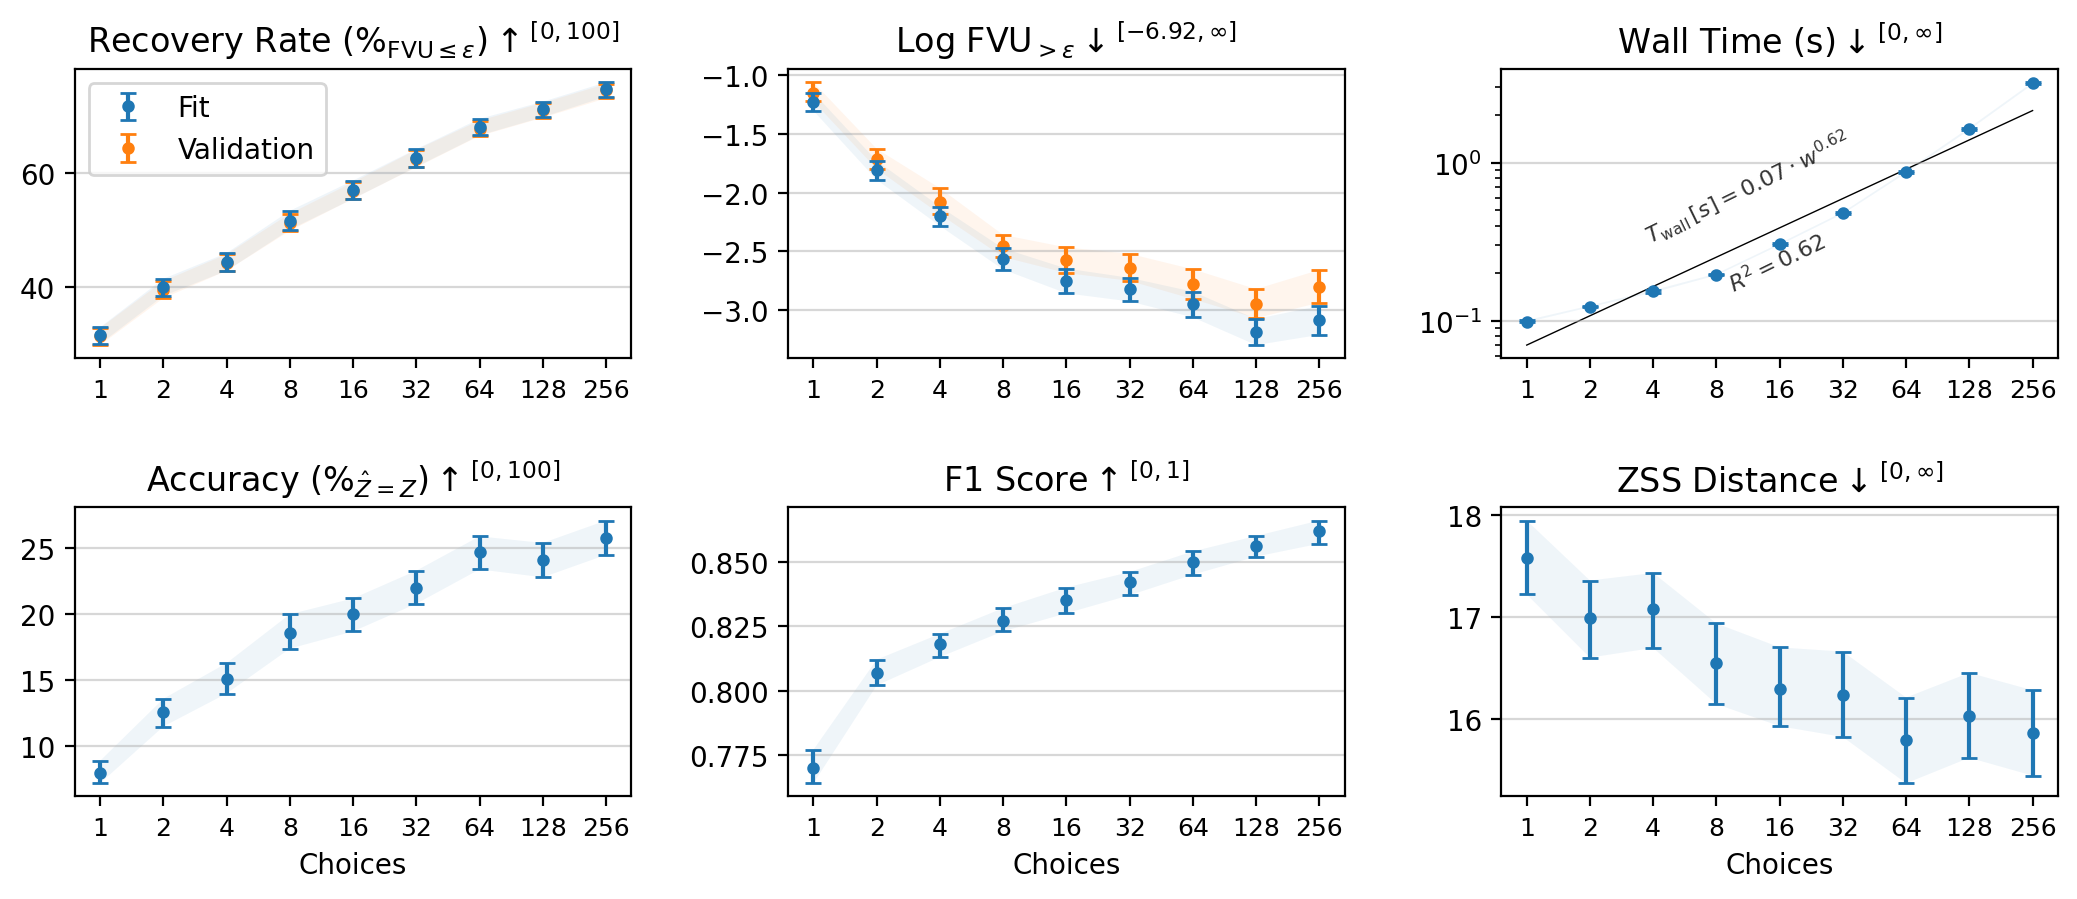

In [51]:
show_metric_list = ['FVU-eps_accuracy', 'log_fvu_not_epsilon', 'wall_time', 'accuracy_best_beam', 'f1_score_best_beam', 'tree_edit_distance_best_beam']
objective_list = ['max', 'min', 'min', 'max', 'max', 'min']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Log FVU$_{>\\epsilon}$', 'Wall Time (s)', 'Accuracy ($\%_{\hat{Z} = Z}$)', 'F1 Score', 'ZSS Distance']
bounds_list = [(0, 100), (np.log10(np.finfo(np.float32).eps).round(2), None), (0, None), (0, 100), (0, 1), (0, None)]
sub_metric_list = ['mean', 'mean', 'mean', 'mean', 'mean', 'mean']
factor_list = [100, 1, 1, 100, 1, 1]
yscale_list = ['linear', 'linear', 'log', 'linear', 'linear', 'linear']
# ylim_list = [(0, 100), (np.log10(np.finfo(np.float32).eps), None), (0, None), (0, 1), (0, None)]
ylim_list = [None] * len(show_metric_list)

x = [configs[model]['generation_config']['choices'] for model in MODELS]

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3.5, ROWS * 2.3), dpi=200)

showed_val_legend = False

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, objective, bounds, yscale) in enumerate(
    zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, objective_list, bounds_list, yscale_list)):

    show_metrics = [show_metric]
    if f'{show_metric}_val' in total_summary_tables[sub_metric]['median'].T.index:
        show_metrics.append(f'{show_metric}_val')
    
    for k, (s, label) in enumerate(zip(show_metrics, ['Fit', 'Validation'])):
        y = total_summary_tables[sub_metric]['median'].T.loc[s] * factor
        y_lower = total_summary_tables[sub_metric]['lower'].T.loc[s] * factor
        y_upper = total_summary_tables[sub_metric]['upper'].T.loc[s] * factor

        ax.errorbar(x, y, yerr=[y - y_lower, y_upper - y], fmt='.', markersize=7, capsize=3, zorder=3 + len(show_metrics) - k, label=label)
        sorted_indices = np.argsort(x)
        ax.fill_between(np.array(x)[sorted_indices], np.array(y_lower)[sorted_indices], np.array(y_upper)[sorted_indices], alpha=0.07, zorder=len(show_metrics) - k)

    if not showed_val_legend:
        ax.legend(loc='upper left')
        showed_val_legend = True

    ax.set_xscale('log', base=2)
    arrow = ('$\\uparrow' if objective == 'max' else '$\\downarrow') + '^{[' + str(bounds[0]) + ', ' + (str(bounds[1]) if bounds[1] is not None else '\\infty') + ']}$'
    ax.set_title(y_label + f'{arrow}')
    ax.set_xticks(x)
    ax.set_xticklabels(x, fontsize=9)

    if i // COLS == ROWS - 1:
        ax.set_xlabel('Choices')

    if show_metric == 'wall_time':
        x_logspace = np.logspace(np.log2(min(x)), np.log2(max(x)), 100, base=2)
        y_fit = np.exp(linear(np.log(x_logspace), *popt))
        ax.plot(x_logspace, y_fit, color='black', linewidth=0.5, label='Fit', zorder=1, alpha=1)
        ax.annotate(f'$T_{{\\text{{wall}}}}\,[s] = {popt[0]:.2f} \\cdot w^{{{popt[1]:.2f}}}$', (0.25, 0.4), xycoords='axes fraction', fontsize=8, rotation=26, alpha=0.8)
        ax.annotate(f'$R^2 = {1- fit_fvu:.2f}$', (0.4, 0.23), xycoords='axes fraction', fontsize=8, rotation=26, alpha=0.8)

    ax.grid(alpha=0.5, axis='y', zorder=2)

    ax.set_yscale(yscale)

    ax.set_ylim(ylim)

for ax in axes.flatten()[len(show_metric_list):]:
    ax.axis('off')

fig.tight_layout(w_pad=2, h_pad=2)

plt.savefig(get_path('results', 'analysis_choices', create=True, filename='analysis_choices_errorbars.svg'))

In [52]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary_lengths = {length: {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()} for length in range(32)}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 100

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data_lengths = {length: pd.concat([df[df['length_target'] == length] for test_set, df in model_dfs.items() if test_set in aggregate_sets]) for length in range(32)}

    for length in tqdm(range(32)):
        for column in compare_columns:
            if column in aggregated_data_lengths[length].columns:
                data = aggregated_data_lengths[length][column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                total_summary_lengths[length][model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary_lengths[length][model][column].keys()

  0%|          | 0/32 [00:00<?, ?it/s]

/tmp/ipykernel_25621/3880369273.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(x)[np.isfinite(x)])
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1649: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  9%|▉         | 3/32 [00:00<00:05,  5.27it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_shape_base_impl.py:393: RuntimeWarning: All-NaN slice encountered
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_shape_base_impl.py:416: RuntimeWarning: All-NaN slice encountered
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))
/h

KeyboardInterrupt: 

In [50]:
total_summary_tables_length = {
    length: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    column: total_summary_lengths[length][model][column][metric][k]
                    for column in compare_columns}
                    for model in total_summary.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for length in range(32)}

In [51]:
from matplotlib.colors import LogNorm

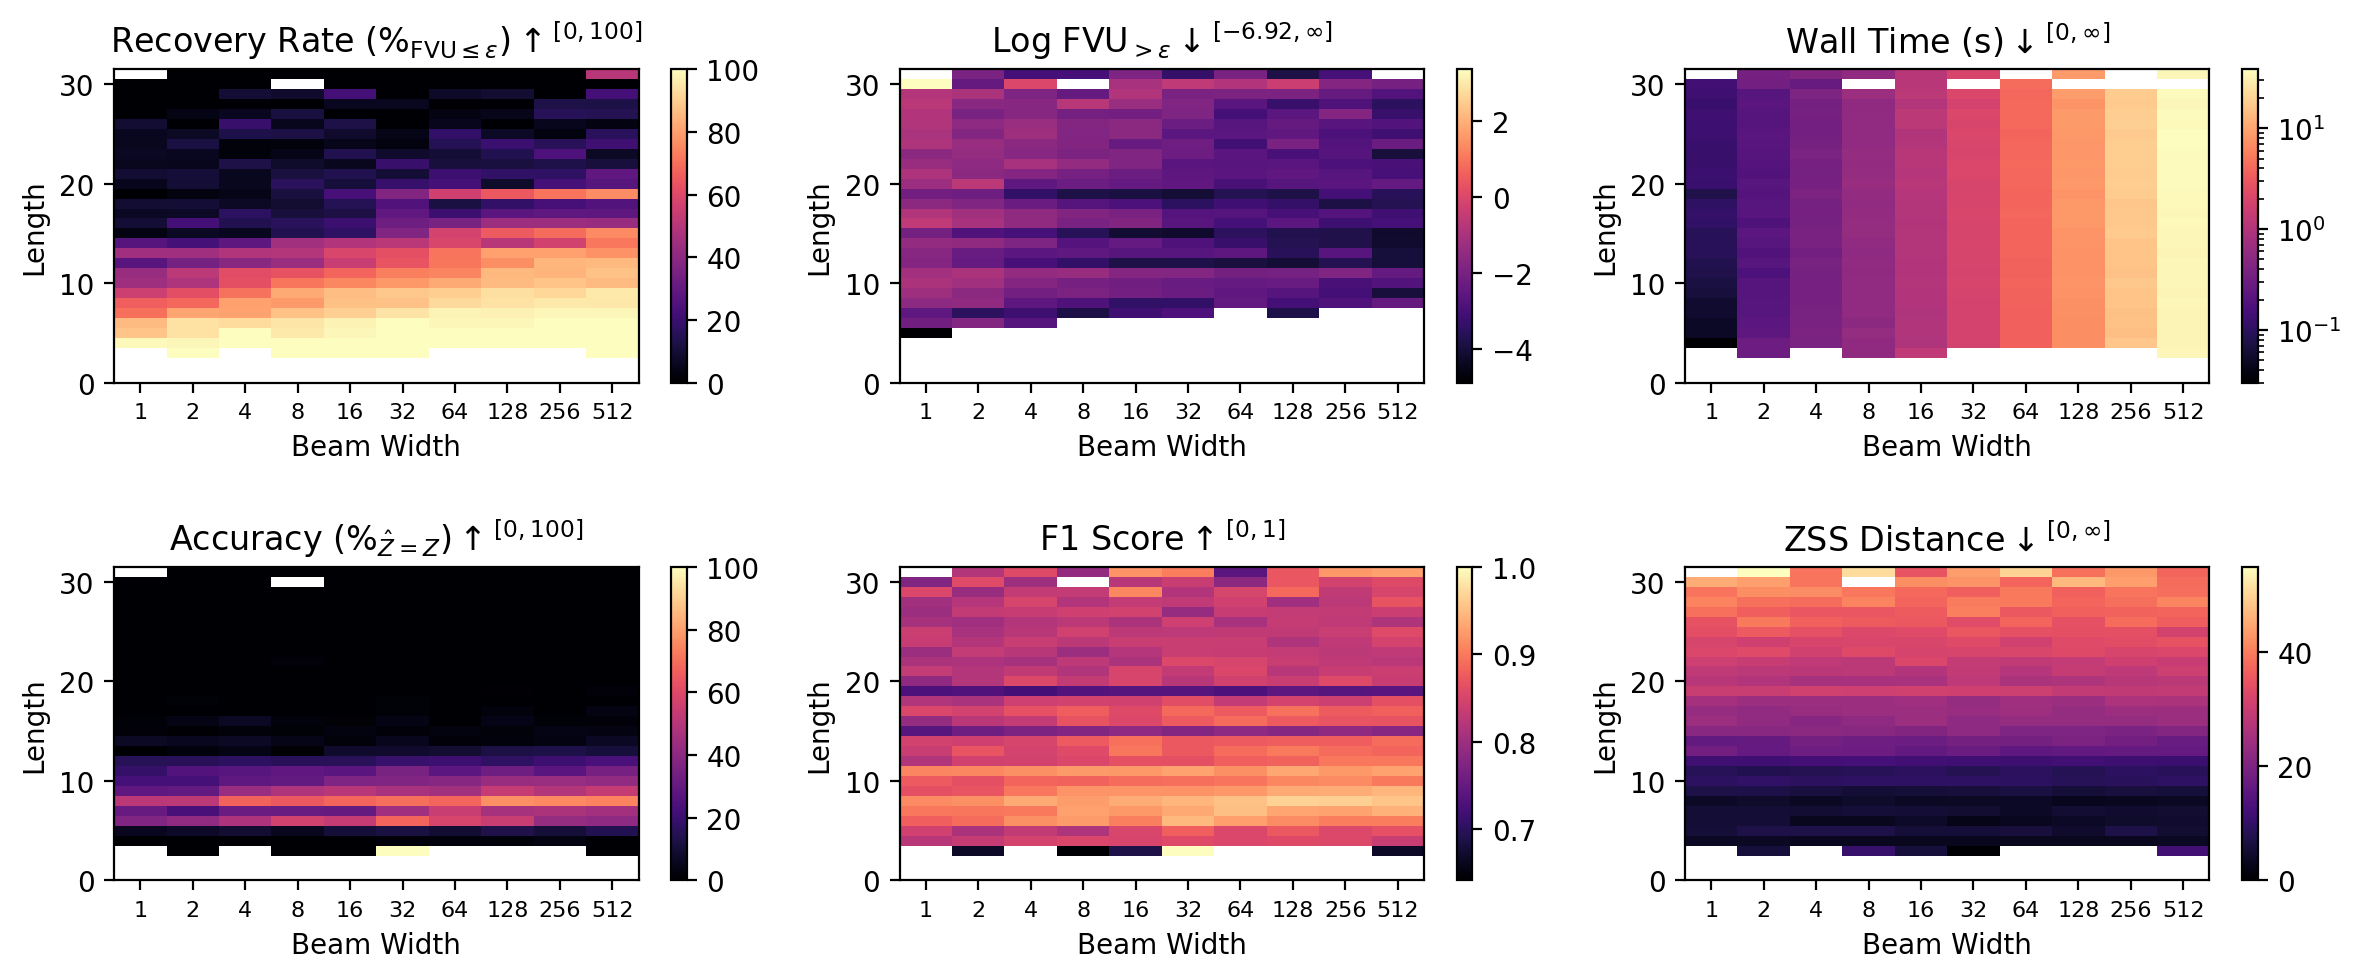

In [52]:
show_metric_list = ['FVU-eps_accuracy', 'log_fvu_not_epsilon', 'wall_time', 'accuracy_best_beam', 'f1_score_best_beam', 'tree_edit_distance_best_beam']
objective_list = ['max', 'min', 'min', 'max', 'max', 'min']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Log FVU$_{>\\epsilon}$', 'Wall Time (s)', 'Accuracy ($\%_{\hat{Z} = Z}$)', 'F1 Score', 'ZSS Distance']
bounds_list = [(0, 100), (np.log10(np.finfo(np.float32).eps).round(2), None), (0, None), (0, 100), (0, 1), (0, None)]
sub_metric_list = ['mean', 'mean', 'mean', 'mean', 'mean', 'mean']
factor_list = [100, 1, 1, 100, 1, 1]
log_norm_list = [False, False, True, False, False, False]
ylim_list = [(0, 31.5)] * len(show_metric_list)

x = np.array([configs[model]['beam_width'] for model in MODELS])
sorted_indices = np.argsort(x)

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 2.5), dpi=200)

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, log_norm, bounds, objective) in enumerate(
    zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, log_norm_list, bounds_list, objective_list)):
    y = np.array([s[sub_metric]['median'].T.loc[show_metric] for s in total_summary_tables_length.values()]) * factor

    mesh = np.meshgrid(np.log2(x[sorted_indices]), np.arange(32))
    colormesh = ax.pcolormesh(mesh[0], mesh[1], y[:, sorted_indices], shading='auto', cmap='magma', norm=LogNorm() if log_norm else None, linewidth=0, rasterized=True)
    # colormesh.set_edgecolor('face')


    ax.set_xticks(np.log2(x))
    ax.set_xticklabels(x, fontsize=8)

    ax.set_ylabel('Length')
    ax.set_xlabel('Beam Width')
    arrow = ('$\\uparrow' if objective == 'max' else '$\\downarrow') + '^{[' + str(bounds[0]) + ', ' + (str(bounds[1]) if bounds[1] is not None else '\\infty') + ']}$'
    ax.set_title(y_label + f'{arrow}')
    
    # Add a little colorbar to each plot
    cb = plt.colorbar(colormesh, ax=ax)

    ax.set_ylim(ylim)

# hist_x = np.arange(32)
# hist_y = [len(aggregated_data_lengths[length]) for length in range(32)]

# hist_plot_x = np.empty(2 * len(hist_x))
# hist_plot_x[0::2] = hist_x - 0.5
# hist_plot_x[1::2] = hist_x + 0.5
# hist_plot_y = np.empty(2 * len(hist_y))
# hist_plot_y[0::2] = hist_y
# hist_plot_y[1::2] = hist_y

# axes.flatten()[-1].fill_betweenx(hist_plot_x, hist_plot_y, color='k', alpha=0.2)
# axes.flatten()[-1].set_xlim(0, None)
# axes.flatten()[-1].set_xlabel('Number of Test Equations')
# axes.flatten()[-1].set_ylabel('Length')
# axes.flatten()[-1].grid(alpha=0.5)
# axes.flatten()[-1].set_ylim(0, 32)
# axes.flatten()[-1].set_title('Aggregated Test Set Distribution')

# Add a phantom colorbar
# cb = plt.colorbar(colormesh, ax=axes.flatten()[-1])
# Hide the colorbar
# cb.ax.set_visible(False)

fig.tight_layout(w_pad=1, h_pad=2)

plt.savefig(get_path('results', 'analysis_beams', create=True, filename='analysis_beams_length_heatmap.svg'))